In [37]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.patches as mpatches

# **GridWorld Environment**

In [38]:
class GridWorld:
    def __init__(self, size=10, obstacles=20, seed=42):
        self.size = size
        self.start = (0, 0)
        self.goal = (size - 1, size - 1)
        random.seed(seed)
        np.random.seed(seed)

        self.obstacles = set()
        while len(self.obstacles) < obstacles:
            cell = (np.random.randint(0, size), np.random.randint(0, size))
            if cell not in [self.start, self.goal]:
                self.obstacles.add(cell)

    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):

        x, y = self.agent_pos
        if action == 0:   # up
            nx, ny = x - 1, y
        elif action == 1: # down
            nx, ny = x + 1, y
        elif action == 2: # left
            nx, ny = x, y - 1
        else:             # right
            nx, ny = x, y + 1


        if (nx < 0 or nx >= self.size or ny < 0 or ny >= self.size or (nx, ny) in self.obstacles):
            nx, ny = x, y

        self.agent_pos = (nx, ny)


        if self.agent_pos == self.goal:
            return self.agent_pos, 0, True
        else:
            return self.agent_pos, -1, False

# **Show obstacle layout**

In [39]:
def show_obstacles(env, savepath=None):
    """Visualize the grid with start, goal, and obstacles."""
    grid = np.zeros((env.size, env.size))
    for (x, y) in env.obstacles:
        grid[x, y] = 1
    gx, gy = env.goal
    grid[gx, gy] = 2
    sx, sy = env.start
    grid[sx, sy] = 3

    plt.figure(figsize=(6,6))
    cmap = plt.cm.get_cmap("tab10", 4)
    plt.imshow(grid, cmap=cmap, origin="upper")

    legend_handles = [
        mpatches.Patch(color=cmap(0), label="Empty"),
        mpatches.Patch(color=cmap(1), label="Obstacle"),
        mpatches.Patch(color=cmap(2), label="Goal"),
        mpatches.Patch(color=cmap(3), label="Start"),
    ]
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("GridWorld Layout (10×10)")
    plt.xticks(range(env.size))
    plt.yticks(range(env.size))
    plt.grid(True, color="gray", linewidth=0.5, alpha=0.5)
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.show()

def print_obstacle_list(env):
    coords = sorted(list(env.obstacles))
    print(f"Total obstacles: {len(coords)}")
    print(coords)


# **Q-learning Algorithm**

In [40]:
def q_learning(env, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000):
    Q = np.zeros((env.size, env.size, 4))
    returns = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0

        while True:
            x, y = state

            if np.random.rand() < epsilon:
                action = np.random.choice(4)
            else:
                action = np.argmax(Q[x, y, :])

            next_state, reward, done = env.step(action)
            nx, ny = next_state


            td_target = reward + gamma * np.max(Q[nx, ny, :])
            td_error  = td_target - Q[x, y, action]
            Q[x, y, action] += alpha * td_error

            state = next_state
            total_reward += reward
            if done:
                break

        returns.append(total_reward)
    return returns


# **Experiment Runner**

In [44]:
def run_experiments():
    env = GridWorld(size=10, obstacles=20, seed=42)

    show_obstacles(env, savepath="grid_layout.png")
    print_obstacle_list(env)

    experiments = {
        "alpha":   {"values": [0.1, 0.3, 0.5, 0.7, 0.9], "fixed": {"gamma":0.9, "epsilon":0.1}},
        "gamma":   {"values": [0.1, 0.3, 0.5, 0.7, 0.9], "fixed": {"alpha":0.1, "epsilon":0.1}},
        "epsilon": {"values": [0.1, 0.3, 0.5, 0.7, 0.9], "fixed": {"alpha":0.1, "gamma":0.9}},
    }

    for param, setup in experiments.items():
        plt.figure(figsize=(8,6))
        for val in setup["values"]:
            args = setup["fixed"].copy()
            args[param] = val
            returns = q_learning(env,
                                 alpha=args.get("alpha", 0.1),
                                 gamma=args.get("gamma", 0.9),
                                 epsilon=args.get("epsilon", 0.1),
                                 episodes=1000)

            if len(returns) >= 20:
                kernel = np.ones(20) / 20
                smoothed = np.convolve(returns, kernel, mode='valid')
                plt.plot(smoothed, label=f"{param}={val}")
            else:
                plt.plot(returns, label=f"{param}={val}")

        plt.title(f"Effect of {param} on Q-learning Performance")
        plt.xlabel("Episode")
        plt.ylabel("Return (Cumulative Reward)")
        plt.legend(title=f"Varying {param}")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        # Save each graph for submission
        plt.savefig(f"{param}_experiment.png", dpi=150)
        plt.show()


/tmp/ipython-input-3896536672.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 4)


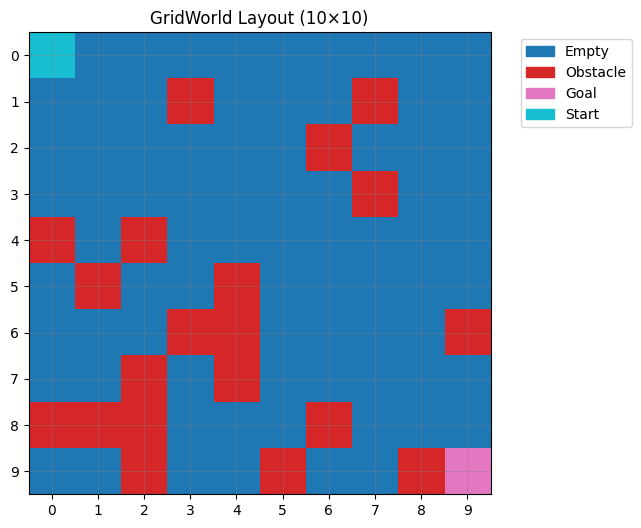

Total obstacles: 20
[(1, 3), (1, 7), (2, 6), (3, 7), (4, 0), (4, 2), (5, 1), (5, 4), (6, 3), (6, 4), (6, 9), (7, 2), (7, 4), (8, 0), (8, 1), (8, 2), (8, 6), (9, 2), (9, 5), (9, 8)]


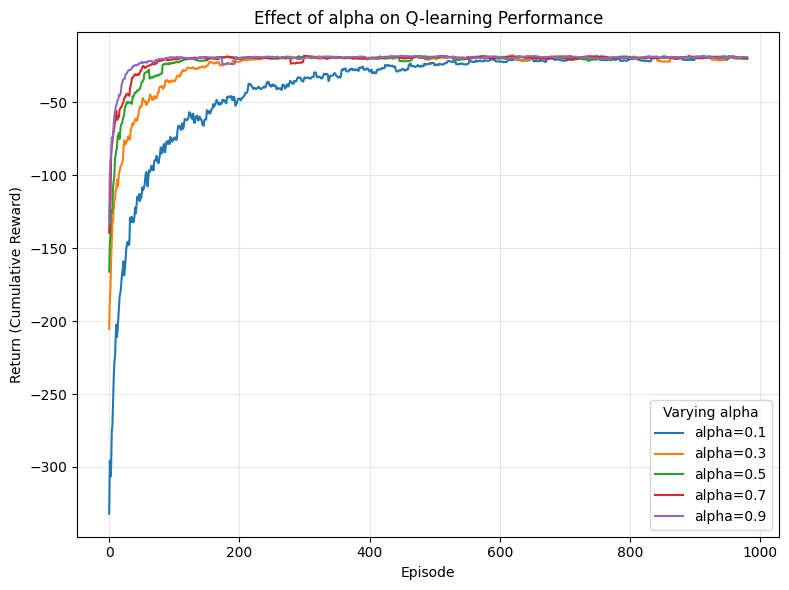

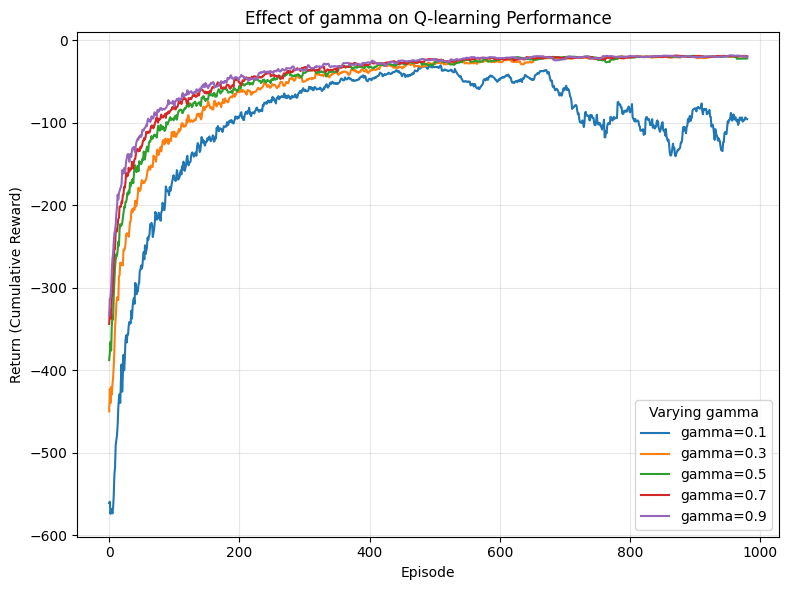

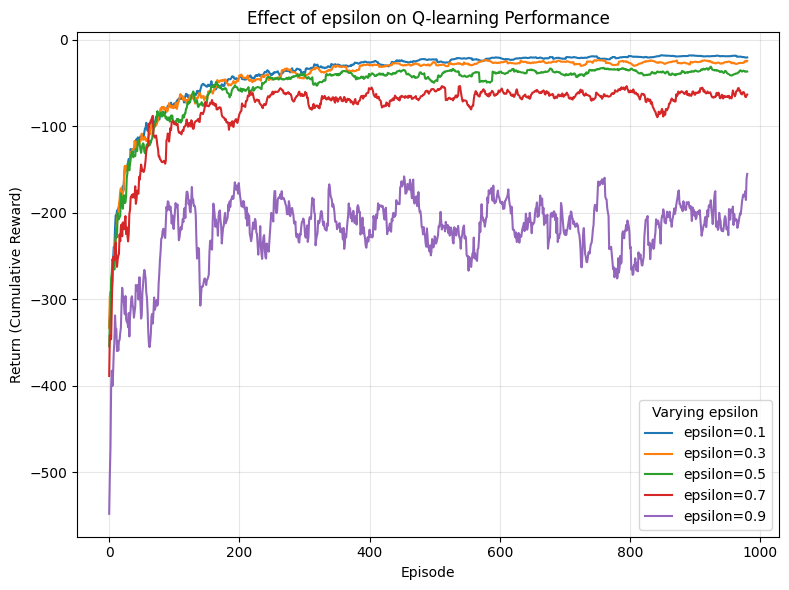

In [45]:
if __name__ == "__main__":
    run_experiments()